In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import tensorflow as tf
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Sequential

from keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Process

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 112, 112
SEQUENCE_LENGTH = 100

DATASET_DIR = '/content/drive/MyDrive/DAiSEE 실습/train'

CLASSES_LIST = ["0", "1", "2", "3"]

In [ ]:
import cv2
import os
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# 비디오에서 프레임 추출 함수 정의
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frames_list.append(resized_frame)

    video_reader.release()
    return frames_list

def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class : {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = to_categorical(labels, num_classes=len(CLASSES_LIST))

    return features, labels, video_files_paths

In [ ]:
# 어노테이션 작업
'''datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)'''

# 데이터셋 생성 // 증강 적용
features, labels, video_files_paths = create_dataset()

Extracting Data of Class : 0
Extracting Data of Class : 1
Extracting Data of Class : 2
Extracting Data of Class : 3


In [ ]:
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

### Split the Data into Train, Test Set

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, shuffle=True, stratify=labels, random_state=2024)

### ConvLSTM Approach

In [ ]:
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), padding='same', activation='tanh', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), padding='same', activation='tanh', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', activation='tanh', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', activation='tanh', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    # display the models summary
    model.summary()

    # return the constructed convlstm model
    return model

In [ ]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_8 (ConvLSTM2D)  (None, 100, 112, 112, 4   1024      
                             )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 100, 56, 56, 4)    0         
 g3D)                                                            
                                                                 
 time_distributed_6 (TimeDi  (None, 100, 56, 56, 4)    0         
 stributed)                                                      
                                                                 
 conv_lstm2d_9 (ConvLSTM2D)  (None, 100, 56, 56, 8)    3488      
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 100, 28, 28, 8)    0         
 g3D)                                                 

In [ ]:
from keras.utils import plot_model

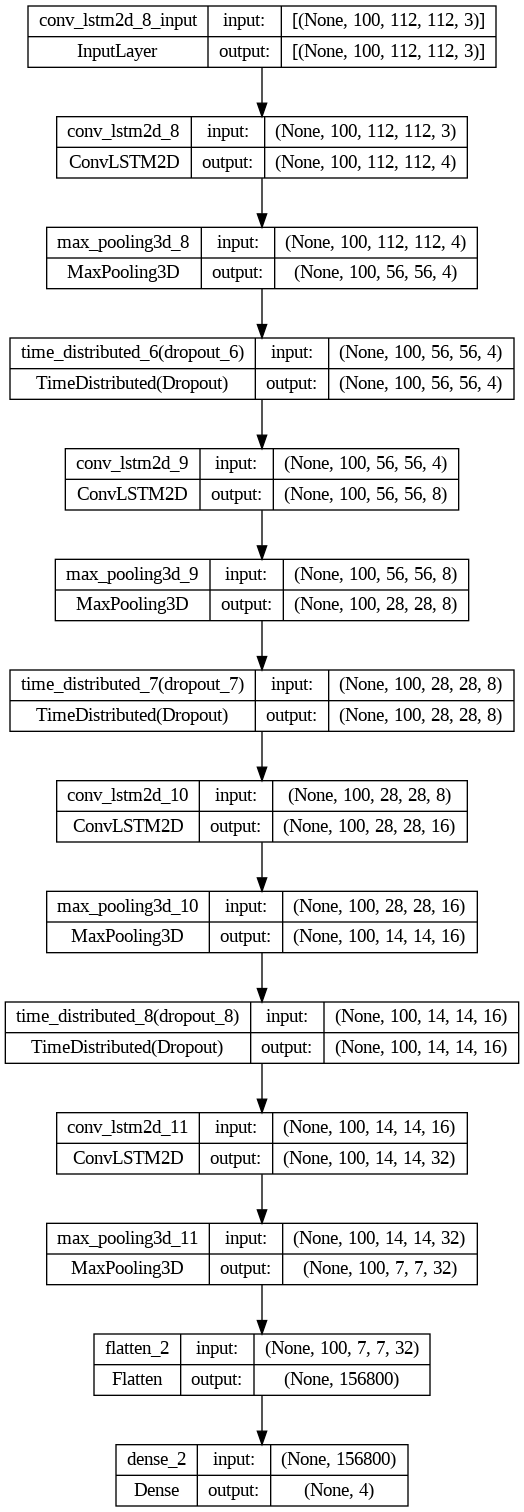

In [ ]:
plot_model(convlstm_model, to_file='convlstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

#### Compile and Train the Model

In [ ]:
# compile the model and specify loss function, optimizer and metrics values to the model
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['Accuracy'])

# start training the model
convlstm_model_training_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=100, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/100
54/54 [==============================] - 63s 1s/step - loss: 1.9062 - Accuracy: 0.2222 - val_loss: 1.5186 - val_Accuracy: 0.1852
Epoch 2/100
54/54 [==============================] - 54s 1s/step - loss: 1.4403 - Accuracy: 0.2639 - val_loss: 1.3611 - val_Accuracy: 0.2593
Epoch 3/100
54/54 [==============================] - 54s 1s/step - loss: 1.3640 - Accuracy: 0.2731 - val_loss: 1.4495 - val_Accuracy: 0.2593
Epoch 4/100
54/54 [==============================] - 55s 1s/step - loss: 1.3286 - Accuracy: 0.3657 - val_loss: 1.5462 - val_Accuracy: 0.2778
Epoch 5/100
54/54 [==============================] - 55s 1s/step - loss: 1.3433 - Accuracy: 0.3056 - val_loss: 1.3630 - val_Accuracy: 0.2593
Epoch 6/100
54/54 [==============================] - 54s 1s/step - loss: 1.2856 - Accuracy: 0.4167 - val_loss: 1.4304 - val_Accuracy: 0.2778
Epoch 7/100
54/54 [==============================] - 55s 1s/step - loss: 1.3105 - Accuracy: 0.3426 - val_loss: 1.3818 - val_Accuracy: 0.2963
Epoch 8/100
5

#### evaluate the trained model

In [ ]:
import matplotlib.pyplot as plt

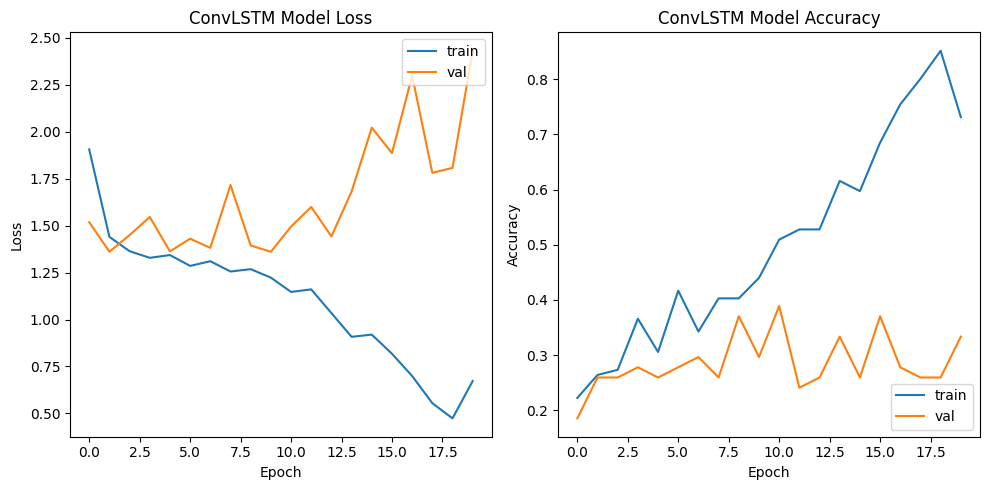

In [ ]:
plt.figure(figsize=(10, 5))

# 손실 그래프
plt.subplot(121)
plt.plot(convlstm_model_training_history.history['loss'])
plt.plot(convlstm_model_training_history.history['val_loss'])
plt.title('ConvLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(convlstm_model_training_history.history['Accuracy'])
plt.plot(convlstm_model_training_history.history['val_Accuracy'])
plt.title('ConvLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = np.argmax(convlstm_model.predict(features_test), axis=1)
y_test = np.argmax(labels_test, axis=1)

print(classification_report(y_pred, y_test))

3/3 [==============================] - 3s 770ms/step
              precision    recall  f1-score   support

           0       0.44      0.37      0.40        19
           1       0.36      0.25      0.30        36
           2       0.36      0.36      0.36        25
           3       0.12      0.27      0.17        11

    accuracy                           0.31        91
   macro avg       0.32      0.31      0.31        91
weighted avg       0.35      0.31      0.32        91



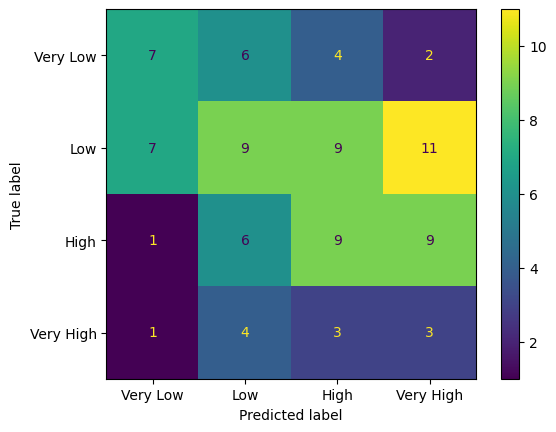

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf = confusion_matrix(y_pred, y_test)

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels = ['Very Low', 'Low', 'High', 'Very High'])
cm_display.plot()

In [ ]:
y_pred

array([0, 1, 3, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 3, 3, 2, 1, 2, 1, 1,
       2, 3, 1, 3, 0, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 2, 3,
       2, 1, 1, 0, 2, 3, 2, 1, 3, 2, 2, 1, 1, 1, 0, 1, 0, 0, 0, 3, 1, 3,
       0, 0, 0, 2, 1, 1, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 2, 3, 0, 1, 0,
       1, 1, 1])

In [ ]:
y_test

array([0, 3, 3, 0, 1, 2, 3, 0, 0, 3, 3, 2, 2, 1, 3, 2, 2, 1, 1, 2, 3, 1,
       2, 3, 1, 1, 0, 2, 3, 1, 2, 3, 1, 2, 2, 1, 3, 3, 1, 3, 3, 3, 2, 1,
       2, 2, 0, 1, 2, 2, 1, 2, 0, 2, 0, 3, 3, 1, 0, 2, 1, 3, 2, 3, 1, 1,
       0, 0, 2, 1, 2, 0, 1, 3, 3, 1, 1, 1, 3, 3, 0, 0, 2, 3, 1, 1, 2, 0,
       0, 3, 2])

In [ ]:
abs(y_test - y_pred)

array([0, 2, 0, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 0, 1, 3, 1, 0, 2,
       0, 1, 1, 1, 0, 1, 1, 1, 3, 0, 2, 2, 2, 0, 0, 1, 1, 3, 2, 0, 0, 2,
       0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0,
       1, 2, 1])

In [ ]:
abs(y_test - y_pred).mean()

0.978021978021978